In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import datetime as dt
import scipy as sp
import os

In [2]:
os.getcwd()

'C:\\Users\\6nico\\Documents\\Académico\\Talento Tech\\Tecnico\\TalentoTech-AVD\\Proyecto'

Los datos se encuentran [aqui](https://www.kaggle.com/datasets/ruslanzalevskikh/oil-well). Hacen referencia a distintas mediciones de un mismo pozo petrolero en Rusia. El pozo fue perforado en 2013 y cuenta con una profundidad de 2400 metros.

Estas son las variables y hacen referencia a lo siguiente:
1. **OilVol**: $\text{m}^3 / \text{día}$ el vólumen de petróleo producido
2. **VolLiq**: $\text{m}^3 / \text{día}$ la cantidad total de líquido (mezcla de petróleo, gas y agua) que el pozo produce diariamente en metros cúbicos.
3. **GasVol**: $\text{m}^3 / \text{día}$ la cantidad de gas producido por el pozo por día en metros cúbicos.
4. **WaterVol**: $\text{m}^3 / \text{día}$ Cantidad de agua extraída.
5. **WaterCut**: % El porcentaje de agua presente en el líquido extraído del pozo; es la proporción de agua en  cantidad total del líquido producido.
6. **WorkTime** Número de horas de operación al día.
7. **DnmcLvl**: $\text{m}$ es la altura a la que se encuentra el fluido dentro del pozo mientras la bomba está en funcionamiento y el pozo está produciendo.
8. **Pressure**: $\text{atm}$ es la presión del reservorio medida en atmósferas, la presión disminuye a medida que el pozo es explotado.

# Limpieza de datos

In [3]:
datos = pd.read_excel("Oil well.xlsx" )

In [4]:
datos.head()

Oil well operation parameters (2013 - 2021 y). Well № 807  \
0                                                NaN          
1                                               Date          
2                                2013-01-01 00:00:00          
3                                2013-01-02 00:00:00          
4                                2013-01-03 00:00:00          

              Unnamed: 1                 Unnamed: 2             Unnamed: 3  \
0                    NaN                        NaN                    NaN   
1  \nOil volume (m3/day)  Volume of liquid (m3/day)  \nGas volume (m3/day)   
2                     49                         70                  13055   
3                     49                         70                  13055   
4                     49                         70                  13055   

              Unnamed: 4      Unnamed: 5       Unnamed: 6  \
0                    NaN             NaN              NaN   
1  Water volume (m3/day)  Water cut (%)   \nWorking hours   
2                     21              29               24   
3                     21              29               24   
4                     21              29               24   

            Unnamed: 7                  Unnamed: 8  
0                  NaN                         NaN  
1  \nDynamic level (m)  \nReservoir pressure (atm)  
2                 1819                         214  
3                 1836                         214  
4                 1788                         214

In [5]:
datos.columns=['Fecha','OilVol','VolLiq','GasVol','WaterVol','WaterCut','WorkHours','DnmcLvl','Pressure']

In [6]:
datos.drop([0,1],inplace=True)

In [7]:
# Convierte la columna Fecha a tipo datetime
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
 
# Establece el índice del d.f. con la columna 'Date'
datos.index = datos['Fecha']

# Elimina la calumna Date del d.f.
datos.drop('Fecha',inplace=True, axis=1); datos

# Convertir todas las columnas de tipo object a numéricas
datos[datos.select_dtypes(include=['object']).columns] = datos.select_dtypes(include=['object']).apply(pd.to_numeric, errors='coerce')


In [8]:
datos.describe()

OilVol       VolLiq        GasVol     WaterVol     WaterCut  \
count  2939.000000  2939.000000   2939.000000  2939.000000  2939.000000   
mean     17.624362    59.464103   4730.146308    41.828853    70.694794   
std       9.689026    18.634101   2598.888524    13.056625     9.534203   
min       0.000000    12.000000      4.000000     9.000000    29.000000   
25%      11.000000    50.000000   3041.500000    33.000000    69.000000   
50%      15.000000    58.000000   3909.000000    43.000000    73.000000   
75%      22.000000    74.000000   5843.500000    50.000000    76.000000   
max      49.000000   113.000000  13113.000000    99.000000   100.000000   

         WorkHours      DnmcLvl     Pressure  
count  2939.000000  2939.000000  2939.000000  
mean     22.344675  1930.383464   157.019054  
std       3.039553   114.543752    32.917150  
min       7.000000  1529.000000   100.000000  
25%      22.000000  1855.000000   129.000000  
50%      24.000000  1890.000000   157.000000  
75%      24.000000  2008.000000   185.500000  
max      24.000000  2137.000000   214.000000

Dado a que los datos corresponden a las mediciones diarias en cada una de las 8 variables en **UN MISMO POZO**, no es posible ajustar un modelo lineal mixto generalizado pues hay que tener al menos dos individuos o clusters. Por lo tanto debemos ajustar un modelo de series de tiempo a cada variable y caracterizar la estructura de correlación para realizar la predicción a 1 o 2 años.

In [8]:
datos.head()

OilVol  VolLiq  GasVol  WaterVol  WaterCut  WorkHours  DnmcLvl  \
Fecha                                                                        
2013-01-01      49      70   13055        21        29         24     1819   
2013-01-02      49      70   13055        21        29         24     1836   
2013-01-03      49      70   13055        21        29         24     1788   
2013-01-04      49      70   13055        21        29         24     1789   
2013-01-05      44      70   11768        26        36         24     1825   

            Pressure  
Fecha                 
2013-01-01       214  
2013-01-02       214  
2013-01-03       214  
2013-01-04       214  
2013-01-05       214

In [9]:
print(datos.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18'],
              dtype='datetime64[ns]', name='Fecha', length=2939, freq=None)


In [11]:
datos.index.isna().sum()

0

El índice de fechas no tiene datos faltantes **NaT**, sin embargo hay saltos entre las fechas y se evidencia en la siguiente celda.

In [12]:
# Calcular las diferencias entre fechas consecutivas en el índice
saltos = datos.index.to_series().diff()

# Mostrar los saltos diferentes a 1 día
saltos_irregulares = saltos[saltos != pd.Timedelta('1 days')]
print(saltos_irregulares)

Fecha
2013-01-01      NaT
2015-06-01   2 days
Name: Fecha, dtype: timedelta64[ns]


Por lo tanto hay que crear de nuevo el índice de fechas de manera que los días sean consecutivos y no hayan saltos para posteriormente establecer la frecuencia diaria de la serie.

In [13]:
# Crear rango de fechas
fechas = pd.date_range(start='2013-01-01', periods=datos.shape[0],freq='D')
# Re indexar el DF con las fechas creadas por la línea anterior (Agregará NaNs donde no coincidan las fechas de 'datos' y 'fechas')
# Para evitar lo anterior hay que hacer uso de 'ffill' y 'bill'
datos = datos.reindex(labels=fechas).ffill().bfill()

In [14]:
# datos.to_csv('DatosLimpiosOilWell',index = True)

# Análisis descriptivo de las series

## Volumen de petróleo

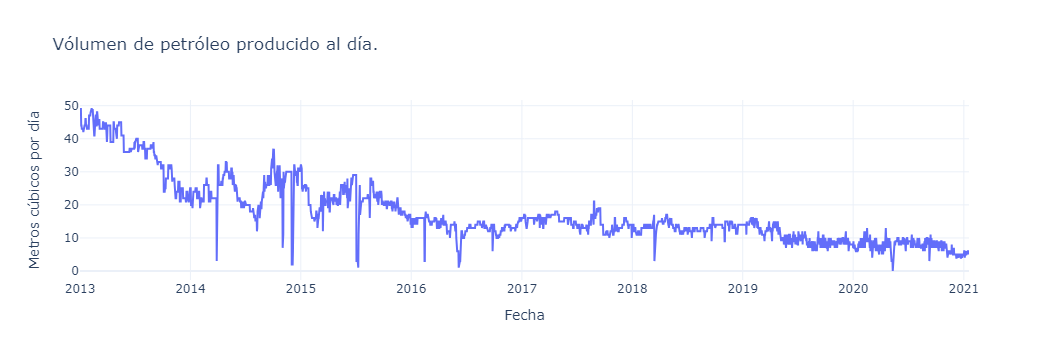

In [10]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y=datos['OilVol'])])
fig.update_layout(title_text="Vólumen de petróleo producido al día.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos por día',template = "plotly_white")


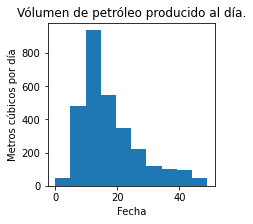

In [17]:
rcParams['figure.figsize'] = 3, 3
plt.hist(datos['OilVol'])
plt.title('Vólumen de petróleo producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

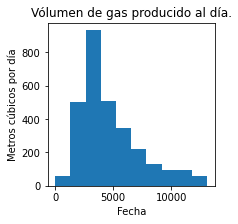

In [18]:
plt.hist(datos['GasVol'])
plt.title('Vólumen de gas producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

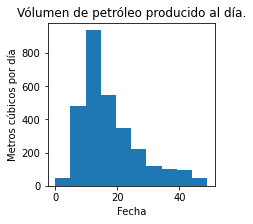

In [19]:
plt.hist(datos['OilVol'])
plt.title('Vólumen de petróleo producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()
#

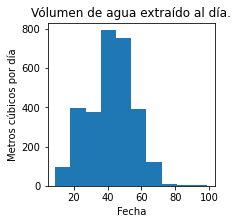

In [20]:
plt.hist(datos['WaterVol'])
plt.title('Vólumen de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

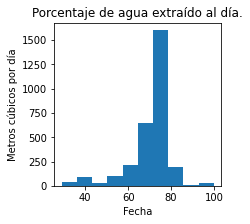

In [21]:
plt.hist(datos['WaterCut'])
plt.title('Porcentaje de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()
#

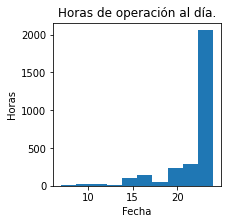

In [22]:
plt.hist(datos['WorkHours'])
plt.title('Horas de operación al día.')
plt.xlabel('Fecha')
plt.ylabel('Horas')
plt.show()
#

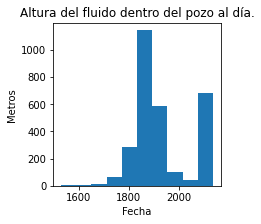

In [23]:
plt.hist(datos['DnmcLvl'])
plt.title('Altura del fluido dentro del pozo al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros')
plt.show()

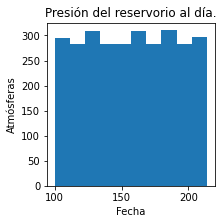

In [24]:
plt.hist(datos['Pressure'])
plt.title('Presión del reservorio al día.')
plt.xlabel('Fecha')
plt.ylabel('Atmósferas')
plt.show()

Se puede ver que la serie presenta una componente de tendencia, en particular es decreciente y tiene sentido en el contexto en que estamos.

Vamos a usar la componente de tendencia que se estima por medio del filtro de promedios móviles.

In [11]:
datos.index = pd.to_datetime(datos.index)

In [12]:
OilVol=datos['OilVol']; print(type(OilVol))

<class 'pandas.core.series.Series'>


### Descomposición 

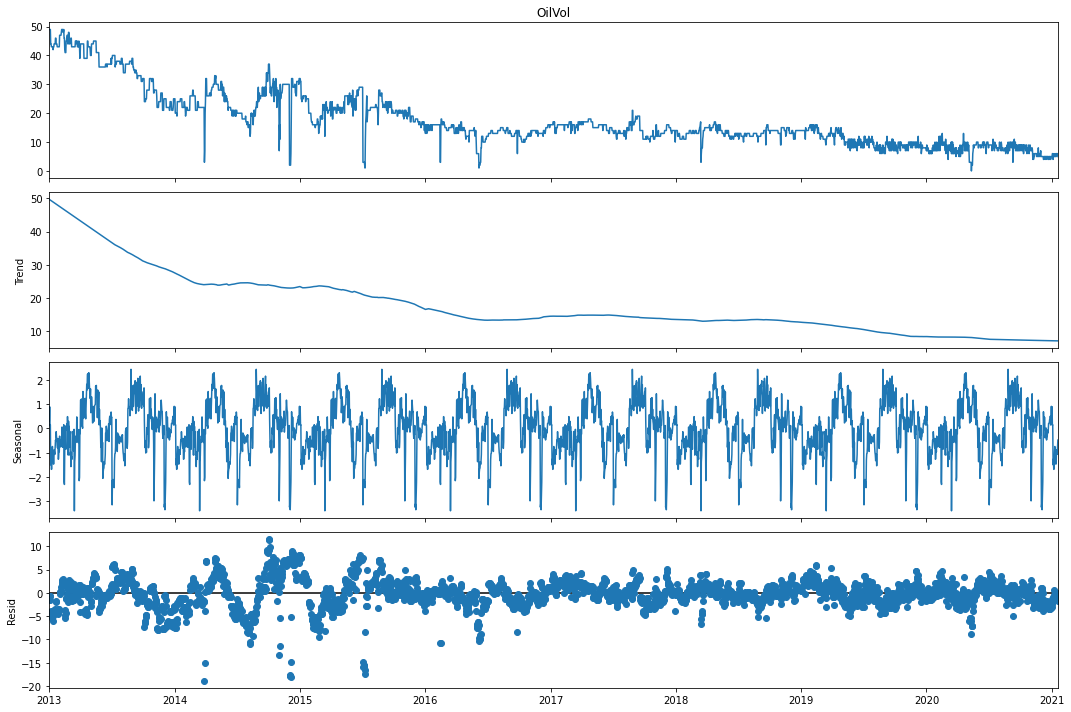

In [13]:
rcParams['figure.figsize'] = 15, 10
####Descomposición usando filtros
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

###También se puede hacer vía STL###
# Descomponer la serie de tiempo con un periodo de 365 días (para estacionalidad anual)
result = seasonal_decompose(OilVol, model='additive', extrapolate_trend=6, period=365)

# Graficar los resultados de la descomposición
desc_OilVol = result.plot()
pyplot.show()



Se usara la estimación de la tendencia por medio del filtro de promedios móviles

In [21]:
Tend_OilVol = result.trend

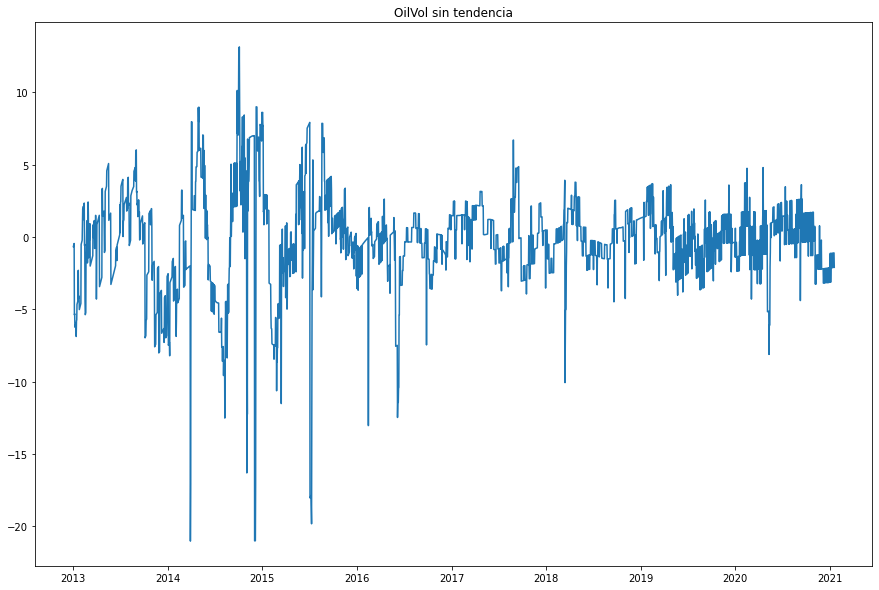

In [17]:
# Serie sin tendencia
NoTen_OilVol = OilVol - Tend_OilVol
plt.plot(NoTen_OilVol)
plt.title('OilVol sin tendencia')
plt.show()

Se hará uso del periodograma y la función de autocorrelación para determinar si existe alguna componente estacional.

### Detección estacionalidad

El valor máximo no. 1 en el que se maximiza el periodograma es en el indice 14 
La frecuencia es: x=0.004763525008506295 con valor de periodograma y=1755.223316888912 
El período es: 209.92857142857142 días
Lo cual corresponde a 6.998 meses

El valor máximo no. 2 en el que se maximiza el periodograma es en el indice 7 
La frecuencia es: x=0.0023817625042531474 con valor de periodograma y=1152.0600860658444 
El período es: 419.85714285714283 días
Lo cual corresponde a 13.995 meses

El valor máximo no. 3 en el que se maximiza el periodograma es en el indice 9 
La frecuencia es: x=0.003402517863218782 con valor de periodograma y=1017.866375951621 
El período es: 293.9 días
Lo cual corresponde a 9.797 meses

El valor máximo no. 4 en el que se maximiza el periodograma es en el indice 11 
La frecuencia es: x=0.004423273222184416 con valor de periodograma y=981.6208264761095 
El período es: 226.0769230769231 días
Lo cual corresponde a 7.536 meses



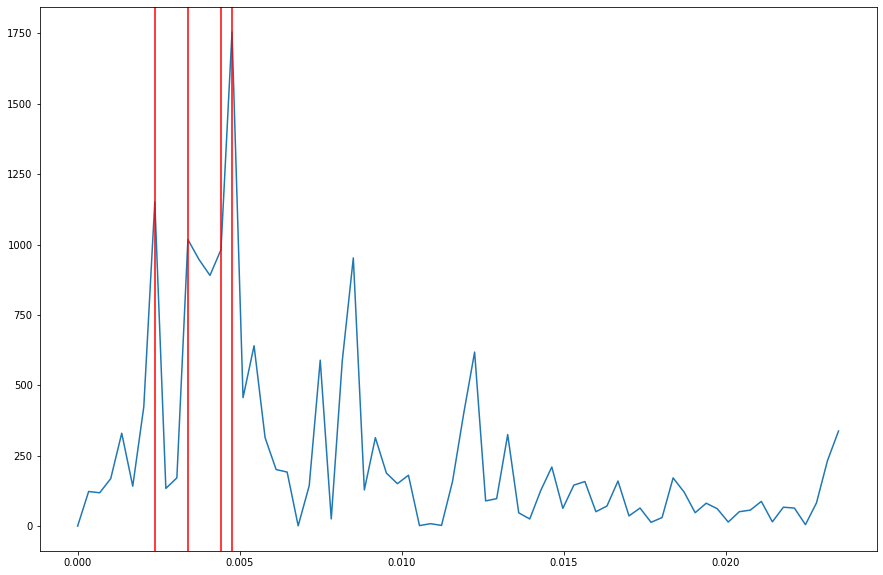

In [18]:
f, Pxx_den=sp.signal.periodogram(NoTen_OilVol)
plt.plot(f[0:70], Pxx_den[0:70])
# plt.axvline(x=0.004763525,color='red')
for i in range(4):
    indice=np.argmax(Pxx_den, axis=0)
    print(f'El valor máximo no. {i+1} en el que se maximiza el periodograma es en el indice {indice} ')
    frecuencia_max=f[indice]
    print(f'La frecuencia es: x={frecuencia_max} con valor de periodograma y={Pxx_den[indice]} ')
    print(f'El período es: {1/frecuencia_max} días')
    print(f'Lo cual corresponde a {round(1/frecuencia_max / 30,3)} meses\n')
    f=np.delete(f,indice)
    Pxx_den=np.delete(Pxx_den,indice)
    plt.axvline(x=frecuencia_max,color='red')
    

# max_index_value = np.argmax(Pxx_den, axis=0)
# print(f'En el índice {max_index_value} se tiene el máximo valor del periodograma')
# frecuencia_max=f[max_index_value]
# print(f'La frecuencia es: x={frecuencia_max}')
# print(f'El período es: y={1/frecuencia_max}')

In [19]:
OilVol[1:30]

Fecha
2013-01-02    49
2013-01-03    49
2013-01-04    49
2013-01-05    44
2013-01-06    44
2013-01-07    43
2013-01-08    43
2013-01-09    43
2013-01-10    43
2013-01-11    43
2013-01-12    42
2013-01-13    43
2013-01-14    43
2013-01-15    44
2013-01-16    44
2013-01-17    44
2013-01-18    44
2013-01-19    46
2013-01-20    46
2013-01-21    44
2013-01-22    44
2013-01-23    44
2013-01-24    43
2013-01-25    43
2013-01-26    43
2013-01-27    43
2013-01-28    43
2013-01-29    43
2013-01-30    43
Name: OilVol, dtype: int64

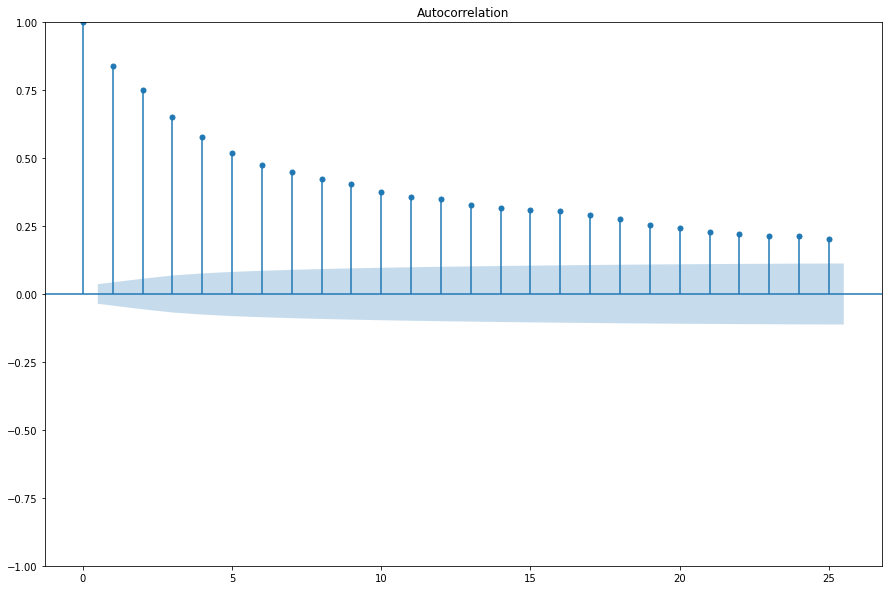

In [25]:
plot_acf(NoTen_OilVol, lags=25)
plt.show()

## Volumen líquido

In [26]:
VolLiq = datos['VolLiq']

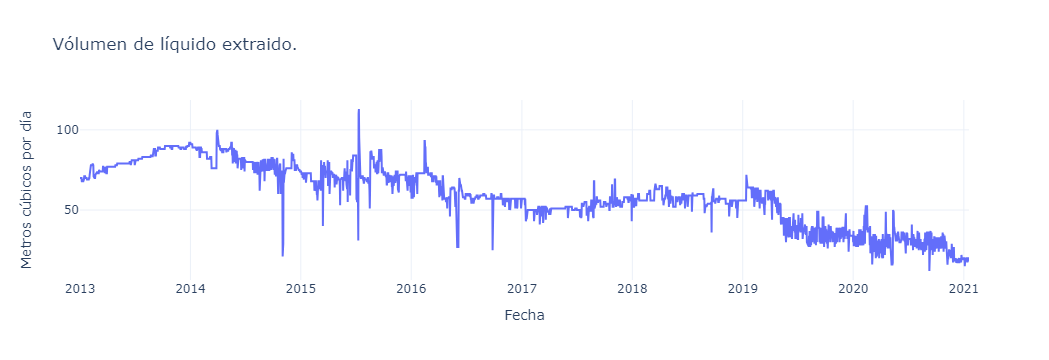

In [27]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y=datos['VolLiq'])])
fig.update_layout(title_text="Vólumen de líquido extraido.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos por día',template = "plotly_white")


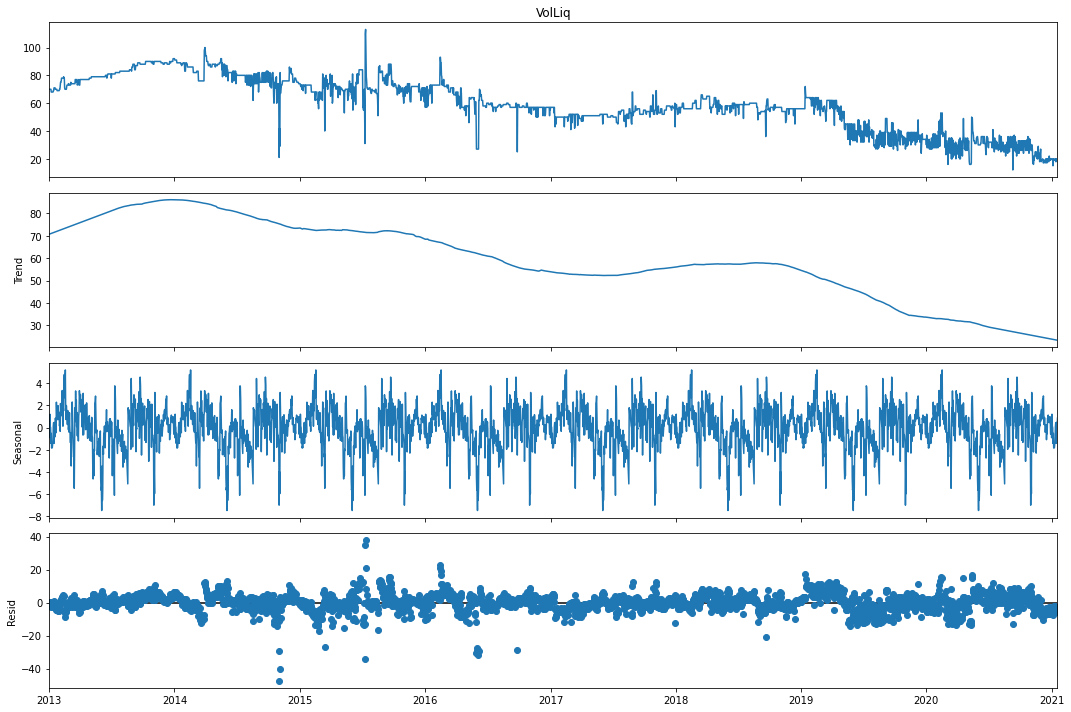

In [34]:
rcParams['figure.figsize'] = 15, 10
###También se puede hacer vía STL###
# Descomponer la serie de tiempo con un periodo de 365 días (para estacionalidad anual)
result = seasonal_decompose(VolLiq, model='additive', extrapolate_trend=6, period=365)

# Graficar los resultados de la descomposición
desc_VolLiq = result.plot()
pyplot.show()



## Volumen de gas producido

## Volumen de agua extraida

## Porcentaje de agua en líquido

## Horas de operación

## Altura del fluido

## Presión